# Classification

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch

import albumentations as A

from scripts.models import CoinClassifier
from scripts.training import train_model
from scripts.utils import split_data, get_images_from_coco, ClassificationDataset, plot_training, get_class, setup_seed

from torch.utils.data import DataLoader
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR

## Hyperparameters and Config

In [4]:
setup_seed(13)

In [5]:
# let's specify paths to training images and masks
images_path = "../data/train"
coins_path = "../data/classification"
labels_path = "../data/classification/labels.json"

annotation_path = "../data/annotations.json"
cls_path = "../data/classification"

In [6]:
# training hyperparameters
batch_size = 8

## Transformations

We first define data augmentations for more robust model. Since our backbones are pretrained on Imagenet, we apply dataset specific normalization to the transformations.

In [7]:
# cut coins from images if necessary and save them as separate images
get_images_from_coco(images_path, annotation_path, cls_path)

Files already there, good to go!


In [26]:
# imagenet specific normalization (was applied also during backbone training)
normalization_kwargs = {
    'mean': (0.485, 0.456, 0.406), 
    'std': (0.229, 0.224, 0.225), 
    'always_apply': True
}

# define data augmentation for train and validation
train_tf = A.Compose([
    A.Resize(width=256, height=256, always_apply=True),
    A.RandomCrop(height=224, width=224, always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0, rotate_limit=45),
    A.RandomBrightnessContrast(),
    A.RandomGamma(),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.Normalize(**normalization_kwargs)
])

valid_tf = A.Compose([
    A.Resize(width=224, height=224, always_apply=True),
    A.Normalize(**normalization_kwargs)  
])

## Modelling

### Predicting Currency

We first build a classifier that will separate between EUR and CHF.

#### Datasets and DataLoaders

In [27]:
# split the image paths into train and validation
images_train, images_val, labels_train, labels_val = split_data(
    coins_path, 0.2, "classification", labels_path, "ccy"
)

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size)
val_loader = DataLoader(val_ds, batch_size=batch_size)

#### Modelling

We use `Segmentation Models Pytorch` for model generation, then we define training arguments and train the model

In [22]:
model = CoinClassifier(num_classes=2, coin_type="ccy")

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.model.head.parameters(), lr=0.0005)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

In [24]:
# train the model
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=20
)

Epoch:   1. Train.      Loss: 0.493 | f1: 0.759: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]
Epoch:   1. Validation. Loss: 0.358 | f1: 0.847: 100%|██████████| 9/9 [00:01<00:00,  8.36it/s]
Epoch:   2. Train.      Loss: 0.302 | f1: 0.920: 100%|██████████| 34/34 [00:04<00:00,  7.46it/s]
Epoch:   2. Validation. Loss: 0.238 | f1: 0.972: 100%|██████████| 9/9 [00:01<00:00,  8.64it/s]
Epoch:   3. Train.      Loss: 0.218 | f1: 0.950: 100%|██████████| 34/34 [00:04<00:00,  7.30it/s]
Epoch:   3. Validation. Loss: 0.178 | f1: 0.972: 100%|██████████| 9/9 [00:01<00:00,  8.83it/s]
Epoch:   4. Train.      Loss: 0.160 | f1: 0.971: 100%|██████████| 34/34 [00:04<00:00,  7.55it/s]
Epoch:   4. Validation. Loss: 0.143 | f1: 0.986: 100%|██████████| 9/9 [00:01<00:00,  8.52it/s]
Epoch:   5. Train.      Loss: 0.138 | f1: 0.978: 100%|██████████| 34/34 [00:04<00:00,  7.24it/s]
Epoch:   5. Validation. Loss: 0.117 | f1: 1.000: 100%|██████████| 9/9 [00:01<00:00,  8.29it/s]
Epoch:   6. Train.      Loss: 0.113 | f1

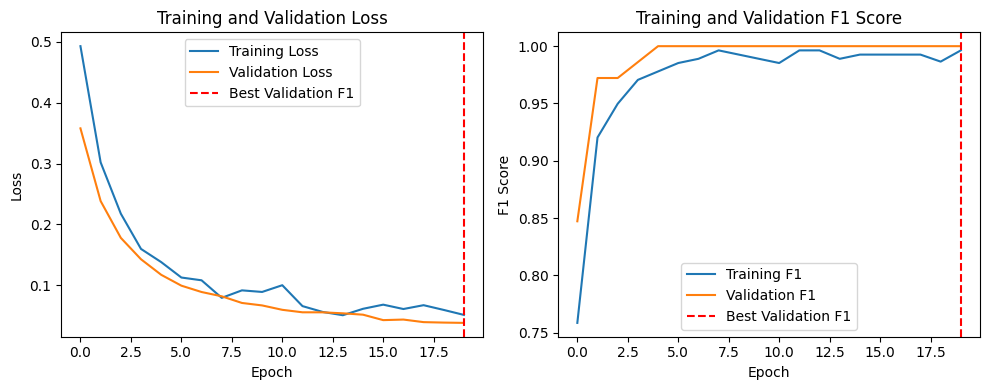

In [25]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

### Predicting EUR

Now we can build a classifier to distinguish between EUR coin types.

#### Datasets and DataLoaders

In [43]:
# split the image paths into train and validation
images_train, images_val, labels_train, labels_val = split_data(
    coins_path, 0.2, "classification", labels_path, "eur"
)

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

#### Modelling

In [44]:
model = CoinClassifier(num_classes=8, coin_type="eur", freeze=False)

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=2, eta_min=1e-6)

In [46]:
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=20
)

Epoch:   1. Train.      Loss: 1.914 | f1: 0.275: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]
Epoch:   1. Validation. Loss: 1.578 | f1: 0.450: 100%|██████████| 5/5 [00:00<00:00,  7.31it/s]
Epoch:   2. Train.      Loss: 1.462 | f1: 0.475: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]
Epoch:   2. Validation. Loss: 1.282 | f1: 0.550: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]
Epoch:   3. Train.      Loss: 1.132 | f1: 0.600: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]
Epoch:   3. Validation. Loss: 1.028 | f1: 0.650: 100%|██████████| 5/5 [00:00<00:00,  7.96it/s]
Epoch:   4. Train.      Loss: 0.842 | f1: 0.750: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
Epoch:   4. Validation. Loss: 0.819 | f1: 0.775: 100%|██████████| 5/5 [00:00<00:00,  7.25it/s]
Epoch:   5. Train.      Loss: 0.646 | f1: 0.850: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
Epoch:   5. Validation. Loss: 0.723 | f1: 0.775: 100%|██████████| 5/5 [00:00<00:00,  7.38it/s]
Epoch:   6. Train.      Loss: 0.576 | f1

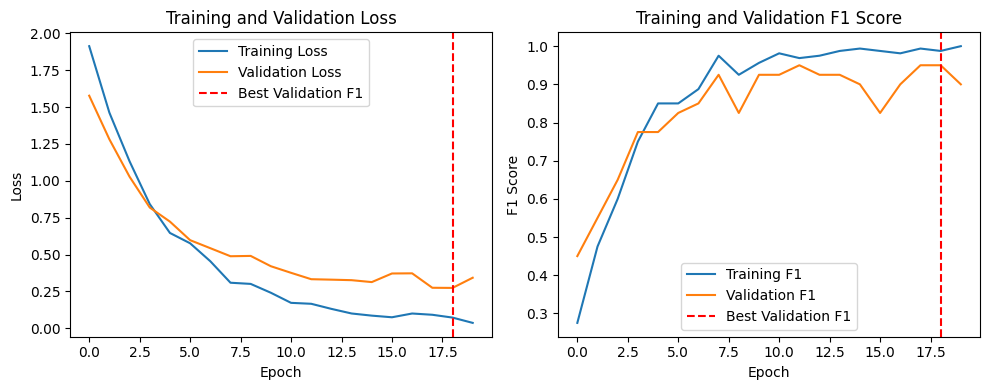

In [47]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

### Predicting CHF heads or tails

#### Datasets and DataLoaders

In [28]:
# split the image paths into train and validation
labels_path = "../data/classification/heads_tails.json"
images_train, images_val, labels_train, labels_val = split_data(
    coins_path, 0.2, "classification", labels_path, "heads-tails"
)

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

#### Modelling

In [40]:
model = CoinClassifier(num_classes=2, coin_type="heads-tails")

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.model.head.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=3)

In [42]:
# train the model
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=30
)

Epoch:   1. Train.      Loss: 0.619 | f1: 0.661: 100%|██████████| 14/14 [00:01<00:00,  7.45it/s]
Epoch:   1. Validation. Loss: 0.593 | f1: 0.667: 100%|██████████| 4/4 [00:00<00:00,  9.11it/s]
Epoch:   2. Train.      Loss: 0.472 | f1: 0.795: 100%|██████████| 14/14 [00:01<00:00,  7.72it/s]
Epoch:   2. Validation. Loss: 0.523 | f1: 0.698: 100%|██████████| 4/4 [00:00<00:00,  9.33it/s]
Epoch:   3. Train.      Loss: 0.398 | f1: 0.857: 100%|██████████| 14/14 [00:01<00:00,  7.64it/s]
Epoch:   3. Validation. Loss: 0.464 | f1: 0.729: 100%|██████████| 4/4 [00:00<00:00,  8.89it/s]
Epoch:   4. Train.      Loss: 0.360 | f1: 0.875: 100%|██████████| 14/14 [00:01<00:00,  7.31it/s]
Epoch:   4. Validation. Loss: 0.421 | f1: 0.823: 100%|██████████| 4/4 [00:00<00:00,  8.46it/s]
Epoch:   5. Train.      Loss: 0.284 | f1: 0.929: 100%|██████████| 14/14 [00:01<00:00,  7.02it/s]
Epoch:   5. Validation. Loss: 0.370 | f1: 0.823: 100%|██████████| 4/4 [00:00<00:00,  8.28it/s]
Epoch:   6. Train.      Loss: 0.255 | f1

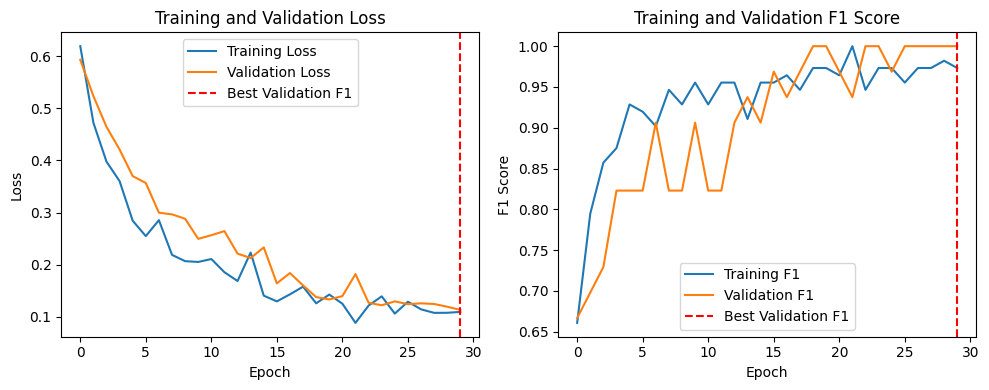

In [43]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

### Predicting CHF tails

#### Datasets and DataLoaders

In [52]:
# split the image paths into train and validation
labels_path = "../data/classification/chf_tails.json"
images_train, images_val, labels_train, labels_val = split_data(
    coins_path, 0.2, "classification", labels_path, "chf-tails"
)

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size=8)
val_loader = DataLoader(val_ds, batch_size=8)

#### Modelling

In [69]:
model = CoinClassifier(num_classes=7, coin_type="chf-tails", freeze=False)

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.model.parameters(), lr=5e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2)

In [71]:
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=20
)

Epoch:   1. Train.      Loss: 1.921 | f1: 0.264: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]
Epoch:   1. Validation. Loss: 1.677 | f1: 0.250: 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]
Epoch:   2. Train.      Loss: 1.436 | f1: 0.514: 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]
Epoch:   2. Validation. Loss: 1.466 | f1: 0.444: 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]
Epoch:   3. Train.      Loss: 1.083 | f1: 0.653: 100%|██████████| 9/9 [00:04<00:00,  2.17it/s]
Epoch:   3. Validation. Loss: 1.458 | f1: 0.486: 100%|██████████| 3/3 [00:00<00:00,  7.77it/s]
Epoch:   4. Train.      Loss: 0.804 | f1: 0.764: 100%|██████████| 9/9 [00:04<00:00,  2.14it/s]
Epoch:   4. Validation. Loss: 1.262 | f1: 0.528: 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]
Epoch:   5. Train.      Loss: 0.587 | f1: 0.847: 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]
Epoch:   5. Validation. Loss: 1.037 | f1: 0.764: 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]
Epoch:   6. Train.      Loss: 0.401 | f1: 0.931: 1

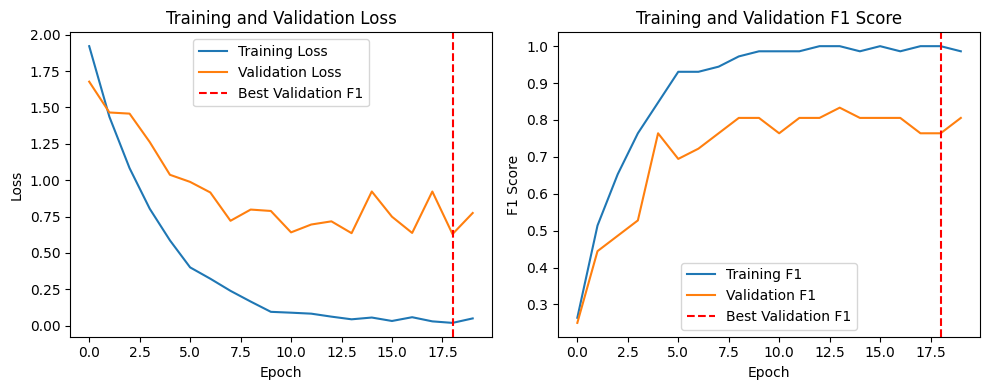

In [73]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

### Predicting CHF heads

#### Datasets and Dataloaders

In [74]:
# split the image paths into train and validation
labels_path = "../data/classification/chf_heads.json"
images_train, images_val, labels_train, labels_val = split_data(
    coins_path, 0.2, "classification", labels_path, "chf-heads"
)

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

#### Modelling

In [85]:
model = CoinClassifier(num_classes=3, coin_type="chf-heads", freeze=False)

In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.model.parameters(), lr=3e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=2, eta_min=1e-6)

In [87]:
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=20
)

Epoch:   1. Train.      Loss: 1.217 | f1: 0.400: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]
Epoch:   1. Validation. Loss: 1.034 | f1: 0.750: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]
Epoch:   2. Train.      Loss: 0.900 | f1: 0.600: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]
Epoch:   2. Validation. Loss: 0.807 | f1: 0.812: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]
Epoch:   3. Train.      Loss: 0.636 | f1: 0.775: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
Epoch:   3. Validation. Loss: 0.713 | f1: 0.750: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]
Epoch:   4. Train.      Loss: 0.470 | f1: 0.900: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]
Epoch:   4. Validation. Loss: 0.607 | f1: 0.812: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]
Epoch:   5. Train.      Loss: 0.356 | f1: 0.950: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]
Epoch:   5. Validation. Loss: 0.417 | f1: 0.812: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]
Epoch:   6. Train.      Loss: 0.268 | f1: 0.950: 1

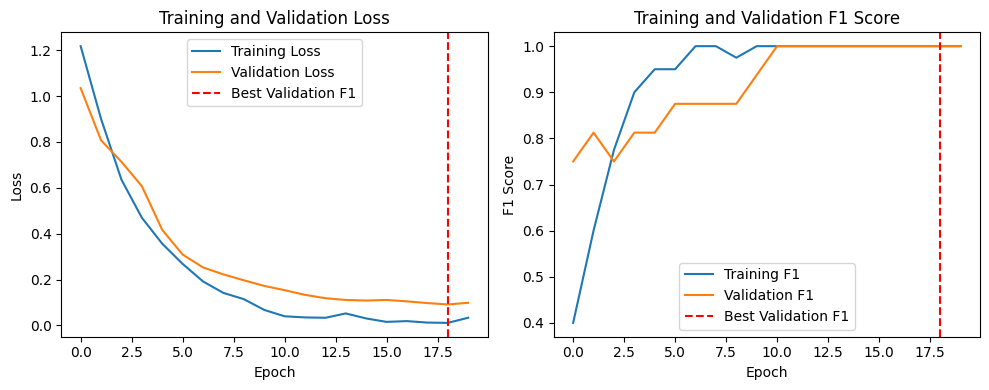

In [88]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)